# Gaussian process surrogate modelling 

## One-dimensional GP regression
### Generating training data

Below we generate a noiseless training data set for $f(x) = \sin(x)$, specifically $f$ at uniform grid on $[0,L]$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Generate noiseless training data where underlying f is sine.
N_train = 20
L = 20
#X_train = np.zeros([N_train, D])
X_train = np.linspace(0, L, N_train)

Y_train = np.sin(X_train)


# Plot training data
fig, ax = subplots(1, 1, figsize = (10, 10))
ax.plot(X_train, Y_train, '*', label = 'training points')
ax.plot(np.linspace(0, L, 100), np.sin(np.linspace(0, L, 100)), 'k-', label = 'f')
ax.set_xlabel(r'$X$', fontsize = 16)
ax.set_ylabel(r'$f(X)$', fontsize = 16)
ax.legend(loc = 'best')
plt.show()

### Fitting a GP through test points

Below we choose a set of x-values, $\textbf{X}^{*}$, for which we will generate random approximations of $f(\textbf{X}^{*})$, based on a Gaussian process fitted to the training data created above.

In [ ]:
### Choosing X* for which I want to approximate f(X*).

#X_star = np.array((3.2, 6.2, 12.5, 15.5))
N_star = 7 # Number of test points
X_star = L * np.random.rand(N_star) # Test points
#N_star = X_star.shape[0]

### Constructing covariance matrix, K, with elements given by k(x_1,x_2), the 'squared exponential' cov kernel.
X = np.concatenate((X_train, X_star))
#cov = lambda x_1, x_2: np.exp(-0.5 * np.transpose(x_1 - x_2) * (x_1 - x_2))    # squared exp. cov
cov = lambda x_1, x_2: np.exp(-0.5 * abs((x_1 - x_2)))     # exp. cov

N = N_train + N_star
K = zeros([N, N])
for i in range(N):
    for j in range(N):
        K[i, j] = cov(X[i], X[j])
        
# Decomposing K for calulation of mean and cov of f(X*).
k = K[: N_train, : N_train] # k(X_train, X_train): covariance between training data and training data.
k_star = K[ N_train :, : N_train] # k(X_star, X_train): covariance between training data and X*.
k_starstar = K[N_train : , N_train : ] # k(X_star, X_star): covariance between X* and X*.

# Calulation of mean and cov of f(X*).
k_inv = np.linalg.inv(k) # Inverse of k need only be calculated once
mean_f_x_star = k_star @ k_inv @ Y_train
V = k_starstar - k_star @ k_inv @ k_star.T

# Plot training data alongside generated f(X*).
fig, ax = subplots(1, 1, figsize = (10, 10))
ax.plot(X_train, Y_train, '*', label = 'training points')
ax.plot(X_star, mean_f_x_star, 'go', label = 'E[f(X*)] (with error bars)')
ax.plot(np.linspace(0, L, 100), np.sin(np.linspace(0, L, 100)), 'k-', label = 'f')
ax.set_xlabel(r'$X$', fontsize = 16)
ax.set_ylabel(r'$f(X)$', fontsize = 16)
ax.errorbar(X_star, mean_f_x_star, yerr=np.diag(V), fmt='go')
ax.legend(loc = 'best')
plt.show()


### Troubleshooting

print("Condition number of k = ", np.linalg.cond(k))
print("X* = ", X_star)
print("E[f(X*)] = ",mean_f_x_star)
print("V(f(X*)) = ", diag(V))
print("True f(X*) = ", np.sin(X_star))
# print("eigenvalues of k = ", np.linalg.eig(k)[0])
# print("eigenvalues of V = ", np.linalg.eig(V)[0])
# print(X)

## Multi-dimensional GP regression
### Generating training data

We want to do GP regression on noiseless "data" from an underlying function, $f:\mathbb{R}^{D}\rightarrow\mathbb{R}$.

Here we create a uniform grid in $[0,1]^D$, take as an example $f(X) = \exp\left(-X^T X\right)$, and evaluate $f$ at the grid points to create training data.

***Make sure to restart kernel between running 1-D and multi-D codes.***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

D = 2 # Number of dimensions.
N = 20 # Number of points along each dimension in grid.

### Create uniform grid points on [0,1]^D.

X = np.linspace(np.zeros(D), np.ones(D), N) # Each column is list of grid-points for each dimension.
Xs = np.hsplit(X, D) # Just for syntax: change array to tuple of vectors.
XDarray = np.array(np.meshgrid(*Xs)) # Has shape (D, N, ..., N), w. D axes of length N.

Yarray = np.zeros(np.repeat(N, D))
#Yarray = np.exp(-(np.sum(XDarray, axis = 0)) ** 2) # Has shape (N, ..., N), w. D axes of length N.
Yarray = np.exp(-np.sum(np.power(XDarray, 2), axis = 0)) # Has shape (N, ..., N), w. D axes of length N.
#test2 = np.exp(-np.sum(np.power(XDarray, 2), axis = 0)) # Has shape (N, ..., N), w. D axes of length N.

# f = lambda x: np.exp(-np.transposex.T @ x)
# Yarray = f(XDarray)

X_train = np.reshape(XDarray, (D, N ** D)) # Store coordinates of training points in a "list".
Y_train = np.reshape(Yarray, N ** D) # Store training point function evaluations in a "list".
N_train = N ** D # Total number of training points.


### Fitting a GP through test points

In [ ]:
#X_train, Y_train, N_train, D, N = train(D,N)


# Choosing X* for which I want to approximate f(X*).
N_star = 2
X_star = np.random.rand(D, N_star)
# X_star = np.ones((D, 1)) * 0.4321
print("X* = ", X_star)

# Constructing covariance matrix, K, with elements given by k(x_1,x_2), the 'squared exponential' cov kernel.
Xs = np.concatenate((X_train, X_star), axis = 1)

# cov = lambda x_1, x_2: np.exp(-0.5 * np.linalg.norm((x_1 - x_2), 2) ** 2)    # squared exp. cov
cov = lambda x_1, x_2: np.exp(-0.5 * np.linalg.norm((x_1 - x_2), 2))     # exp. cov
vCov = np.vectorize(cov)

N = N_train + N_star
K = np.zeros([N, N])
      
# for i in range(N):
#     for j in range(N):
#         K[i, j] = cov(Xs[:, i], Xs[:, j])

for i  in range(N):
    delta = Xs[:,i:(i+1)] - Xs
    K[:,i] = np.exp(-np.sum(delta ** 2, 0) ** 0.5)
        
# Decomposing K for calulation of mean and cov of f(X*).
k = K[: N_train, : N_train] # k(X_train, X_train): covariance between training data and training data.
k_star = K[ N_train :, : N_train] # k(X_star, X_train): covariance between training data and X*.
k_starstar = K[N_train : , N_train : ] # k(X_star, X_star): covariance between X* and X*.

# Calulation of mean and cov of f(X*).
k_inv = np.linalg.inv(k + 0 * (10 ** -11) * np.identity(N_train)) # Inverse of K need only be calculated once

mean_f_x_star = k_star @ k_inv @ Y_train.T
print("E[f(X*)] = ",mean_f_x_star)
# V = k_starstar - k_star @ k_inv @ k_star.T
# print("V(f(X*)) = ", diag(V))

#print("condition number of K = ", np.linalg.cond(K))
print("condition number of k = ", np.linalg.cond(k))

In [ ]:
#Y_star = np.exp(-(np.sum(X_star, axis = 0) ** 2))
Y_star = np.exp(-np.sum(np.power(X_star, 2), axis = 0)) 

print("True f(X*) = ", Y_star)
RelError = np.mean(np.abs(mean_f_x_star - Y_star)/Y_star)
print(RelError)

This becomes numerically very unstable for both choices of covariance function as $N\times D$ increases; however, the exponential covariance function performs better when the squared exponential covariance functions starts to struggle.

Implement sparse grid for training data. Look at decay of error for single test point while fixing dimension and refining training grid.

In [ ]:
#print("eigenvalues of k = ", np.linalg.eig(k)[0])

## Convergence analysis

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
from pylab import *
import time

def GP(D, Nd):
    ### Create uniform grid points on [0,1]^D.

    tStart = time.time()
    X = np.linspace(np.zeros(D), np.ones(D), Nd) # Each column is list of grid-points for each dimension.
    Xs = np.hsplit(X, D) # Just for syntax: change array to tuple of vectors.
    XDarray = np.array(np.meshgrid(*Xs)) # Has shape (D, N,..., N), w. D axes of length Nd.

    Yarray = np.zeros(np.repeat(Nd, D))
    # Yarray = np.exp(-(np.sum(XDarray, axis = 0)) ** 2) # Has shape (N,..., N), w. D axes of length Nd.
    Yarray = np.exp(-np.sum(np.power(XDarray, 2), axis = 0)) # Has shape (N, ..., N), w. D axes of length Nd.

    X_train = np.reshape(XDarray, (D, Nd ** D)) # Store coordinates of training points in a "list".
    Y_train = np.reshape(Yarray, Nd ** D) # Store training point function evaluations in a "list".
    N_train = Nd ** D # Total number of training points.
    
    print("Gen Took {} min".format((time.time()-tStart)/60.)); tStart=time.time();
    # Choosing X* for which I want to approximate f(X*).
    N_star = 20
    X_star = np.random.rand(D, N_star)
    # X_star = np.ones((D, 1)) * 0.4321
    # print("X* = ", X_star)

    # Constructing covariance matrix, K, with elements given by k(x_1,x_2), the 'squared exponential' cov kernel.
    Xs = np.concatenate((X_train, X_star), axis = 1)

    # cov = lambda x_1, x_2: np.exp(-0.5 * np.linalg.norm((x_1 - x_2), 2) ** 2)    # squared exp. cov
    cov = lambda x_1, x_2: np.exp(-0.5 * np.linalg.norm((x_1 - x_2), 2))     # exp. cov

    N = N_train + N_star
    K = np.zeros([N, N])

#     for i in range(N):
#         for j in range(N):
#             K[i, j] = cov(Xs[:, i], Xs[:, j])
            
    for i  in range(N):
        delta = Xs[:,i:(i+1)] - Xs
        K[:,i] = np.exp(-np.sum(delta ** 2, 0) ** 0.5)
    
    print("Cov Took {} min".format((time.time()-tStart)/60.)); tStart=time.time();
    
    # Decomposing K for calulation of mean and cov of f(X*).
    k = K[: N_train, : N_train] # k(X_train, X_train): covariance between training data and training data.
    k_star = K[ N_train :, : N_train] # k(X_star, X_train): covariance between training data and X*.
    k_starstar = K[N_train : , N_train : ] # k(X_star, X_star): covariance between X* and X*.

    # Calulation of mean and cov of f(X*).
    k_inv = np.linalg.inv(k + 1 * (10 ** -15) * np.identity(N_train)) # Inverse of K need only be calculated once

    print("Inv Took {} min".format((time.time()-tStart)/60.)); tStart=time.time();
    
    mean_f_x_star = k_star @ k_inv @ Y_train.T
    #V = k_starstar - k_star @ k_inv @ k_star.T
    
    # Y_star = np.exp(-(np.sum(X_star, axis = 0) ** 2))
    Y_star = np.exp(-np.sum(np.power(X_star, 2), axis = 0))
    
    RelError = np.mean(np.abs(mean_f_x_star - Y_star)/Y_star)
    print("RE = ", RelError)
    print("Mean of GP took {} min".format((time.time()-tStart)/60.)); tStart=time.time();
#     return(RelError, np.linalg.cond(K))
    return(RelError)

### Convergence in 1D

In [42]:
totStart = time.time();
D = 1
ns = np.arange(400,2400,400)
nn = ns.size

RelError = np.zeros(nn)
variance = np.zeros(nn)
condK = np.zeros(nn)

for i in range(nn):
    # RelError[i], condK[i] = GP(D, ns[i])
    RelError[i] = GP(D, ns[i])
print("Entire code took {} min: ".format((time.time()-totStart)/60.));

Gen Took 9.059906005859375e-06 min
Cov Took 0.00036440292994181317 min
Inv Took 7.839600245157878e-05 min
RE =  9.989377501630066e-07
Mean of GP took 7.3552131652832035e-06 min
Gen Took 1.2139479319254557e-05 min
Cov Took 0.0007165710131327312 min
Inv Took 0.0003942688306172689 min
RE =  2.4890430170410355e-07
Mean of GP took 7.3909759521484375e-06 min
Gen Took 7.74065653483073e-06 min
Cov Took 0.0008055448532104492 min
Inv Took 0.0008687853813171386 min
RE =  1.229599384101929e-07
Mean of GP took 1.4038880666097005e-05 min
Gen Took 8.153915405273438e-06 min
Cov Took 0.0015043536822001138 min
Inv Took 0.0018772443135579428 min
RE =  6.282164697442436e-08
Mean of GP took 2.6516119639078776e-05 min
Gen Took 8.738040924072265e-06 min
Cov Took 0.0021811445554097493 min
Inv Took 0.0034055193265279133 min
RE =  4.482927879027422e-08
Mean of GP took 4.54862912495931e-05 min
Entire code took 0.012416799863179525 min: 


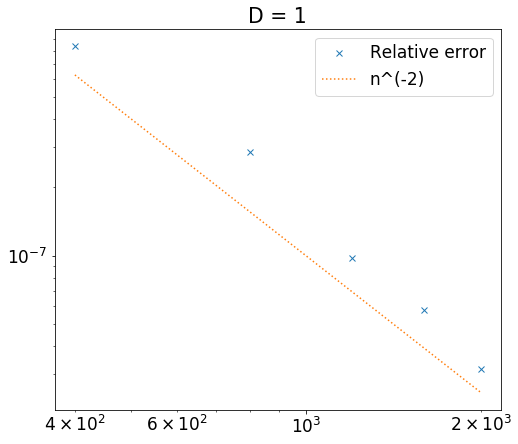

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7))
# axs = axs.ravel()

axs.loglog(ns**D, RelError, 'x', label='Relative error')
axs.loglog(ns**D, 1e-1 * (ns**D)**-2., ':', label='n^(-2)')
axs.legend() # turn on legend
axs.set_title('D = '+str(D))

# axs[0].loglog(ns**D, RelError, 'x', label='Relative error')
# axs[0].loglog(ns**D, 1e-1 * (ns**D)**-1., ':')
# axs[0].legend() # turn on legend
# axs[0].set_title('D = '+str(D))

# axs[1].loglog(ns**D, condK, 'x', label='Cond(K)')
# axs[1].legend() # turn on legend
# axs[1].set_title('D = '+str(D))

plt.show()

### Convergence in 2D

In [43]:
totStart = time.time();
D = 2
ns = np.arange(2, 62, 2)
nn = ns.size

RelError = np.zeros(nn)
variance = np.zeros(nn)
condK = np.zeros(nn)

for i in range(nn):
    # RelError[i], condK[i] = GP(D, ns[i])
    RelError[i] = GP(D, ns[i])
print("Entire code took {} min: ".format((time.time()-totStart)/60.));

Gen Took 2.4120012919108074e-05 min
Cov Took 5.5738290150960286e-05 min
Inv Took 4.275639851888021e-06 min
RE =  0.1854475315005444
Mean of GP took 6.9340070088704424e-06 min
Gen Took 2.2792816162109374e-05 min
Cov Took 4.1421254475911455e-05 min
Inv Took 8.69433085123698e-06 min
RE =  0.008301306619844953
Mean of GP took 4.839897155761719e-06 min
Gen Took 2.400477727254232e-05 min
Cov Took 3.266334533691406e-05 min
Inv Took 8.952617645263671e-06 min
RE =  0.0017861113033395624
Mean of GP took 7.470448811848958e-06 min
Gen Took 1.5572706858317056e-05 min
Cov Took 4.306634267171224e-05 min
Inv Took 9.040037790934244e-06 min
RE =  0.0009180107131878297
Mean of GP took 5.666414896647135e-06 min
Gen Took 7.351239522298177e-06 min
Cov Took 6.545384724934896e-05 min
Inv Took 9.0638796488444e-06 min
RE =  0.0006213303965669688
Mean of GP took 5.145867665608724e-06 min
Gen Took 6.369749704996744e-06 min
Cov Took 6.542205810546874e-05 min
Inv Took 1.0101000467936198e-05 min
RE =  0.000711472712

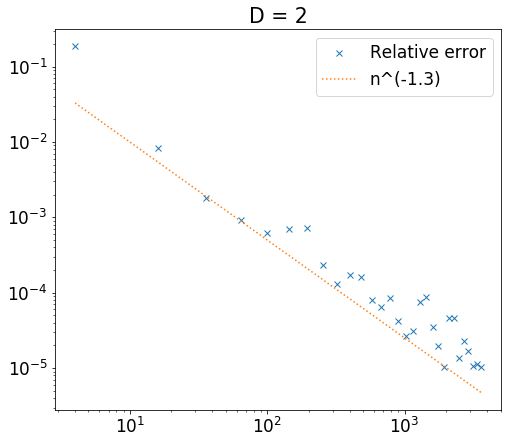

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7))
# axs = axs.ravel()

axs.loglog(ns**D, RelError, 'x', label='Relative error')
axs.loglog(ns**D, 2*1e-1 * (ns**D)**-1.3, ':', label='n^(-1.3)')
axs.legend() # turn on legend
axs.set_title('D = '+str(D))

# axs[0].loglog(ns**D, RelError, 'x', label='Relative error')
# axs[0].loglog(ns**D, 1e-1 * (ns**D)**-1., ':')
# axs[0].legend() # turn on legend
# axs[0].set_title('D = '+str(D))

# axs[1].loglog(ns**D, condK, 'x', label='Cond(K)')
# axs[1].legend() # turn on legend
# axs[1].set_title('D = '+str(D))

plt.show()

### Convergence in 3D

In [ ]:
D = 3
ns = np.arange(1, 16, 1)
nn = ns.size

RelError = np.zeros(nn)
variance = np.zeros(nn)
condK = np.zeros(nn)

for i in range(nn):
    # RelError[i], condK[i] = GP(D, ns[i])
    RelError[i] = GP(D, ns[i])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7))
# axs = axs.ravel()

axs.loglog(ns**D, RelError, 'x', label='Relative error')
axs.loglog(ns**D, 1e-1 * (ns**D)**-.5, ':', label='n^(-2)')
axs.legend() # turn on legend
axs.set_title('D = '+str(D))

# axs[0].loglog(ns**D, RelError, 'x', label='Relative error')
# axs[0].loglog(ns**D, 1e-1 * (ns**D)**-1., ':')
# axs[0].legend() # turn on legend
# axs[0].set_title('D = '+str(D))

# axs[1].loglog(ns**D, condK, 'x', label='Cond(K)')
# axs[1].legend() # turn on legend
# axs[1].set_title('D = '+str(D))

plt.show()

In [3]:
D = 5
ns = np.arange(1, 8, 1)
nn = ns.size

RelError = np.zeros(nn)
variance = np.zeros(nn)
condK = np.zeros(nn)

for i in range(nn):
    # RelError[i], condK[i] = GP(D, ns[i])
    RelError[i] = GP(D, ns[i])

Gen Took 4.269679387410482e-05 min
Cov Took 6.0113271077473957e-05 min
Inv Took 8.031129837036133e-05 min
RE =  0.6477652064291516
Mean of GP took 4.800160725911458e-06 min
Gen Took 1.644293467203776e-05 min
Cov Took 3.911654154459635e-05 min
Inv Took 0.000484776496887207 min
RE =  0.21007611084752295
Mean of GP took 2.0523866017659504e-05 min
Gen Took 1.180569330851237e-05 min
Cov Took 0.0002012054125467936 min
Inv Took 9.676615397135417e-05 min
RE =  0.020106831813741555
Mean of GP took 5.95251719156901e-06 min
Gen Took 1.0538101196289063e-05 min
Cov Took 0.0009429375330607096 min
Inv Took 0.0007690350214640299 min
RE =  0.005944291547760806
Mean of GP took 3.114144007364909e-05 min
Gen Took 1.087188720703125e-05 min
Cov Took 0.0067059000333150225 min
Inv Took 0.012047266960144043 min
RE =  0.0031402151039930087
Mean of GP took 0.00014585256576538086 min
Gen Took 1.877148946126302e-05 min
Cov Took 0.037692431608835855 min
Inv Took 0.13631624778111776 min
RE =  0.0016225594881355684
M

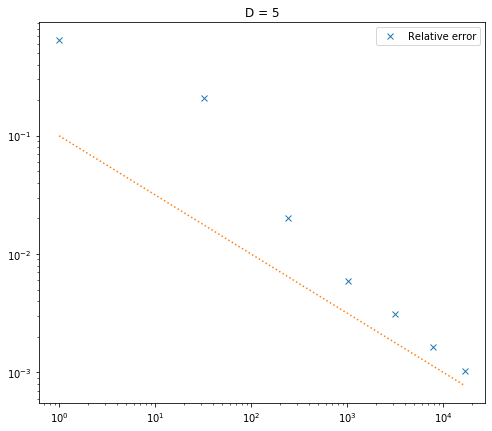

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7))
# axs = axs.ravel()

axs.loglog(ns**D, RelError, 'x', label='Relative error')
axs.loglog(ns**D, 1e-1 * (ns**D)**-.5, ':', label='n^(-2)')
axs.legend() # turn on legend
axs.set_title('D = '+str(D))

# axs[0].loglog(ns**D, RelError, 'x', label='Relative error')
# axs[0].loglog(ns**D, 1e-1 * (ns**D)**-1., ':')
# axs[0].legend() # turn on legend
# axs[0].set_title('D = '+str(D))

# axs[1].loglog(ns**D, condK, 'x', label='Cond(K)')
# axs[1].legend() # turn on legend
# axs[1].set_title('D = '+str(D))

plt.show()